Test of synchronizer.py

In [1]:
import numpy as np
import pandas as pd
import mne
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample

from source.data_loader import load_eeg_data, open_json_file, select_recording, read_time_domain_data

In [2]:
def find_eeg_peak(raw_eeg, freq_low, freq_high, decim, duration_sec=120, save_dir=None, log_file="sync_log.txt"):
    """
    Finds the highest synchronization peak index in EEG data within a specified frequency band.

    Args:
        raw_eeg (mne.io.Raw): The raw EEG data object to analyze.
        freq_low (float): Lower bound of the frequency range of interest.
        freq_high (float): Upper bound of the frequency range of interest.
        decim (int): Decimation factor for downsampling.
        duration_sec (int, optional): Duration of the cropped EEG window (default: 120 sec).
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved.
        log_file (str, optional): Path to the log file where peak detection results will be saved.

    Returns:
        int: Peak index in EEG sampling frequency.
        float: Peak time in seconds.
    """

    # Crop and filter EEG
    raw_cropped = raw_eeg.copy().crop(tmax=duration_sec) 
    raw_filtered = raw_cropped.copy().filter(l_freq=freq_low, h_freq=freq_high)  

    fs = raw_filtered.info["sfreq"]
    freqs = np.arange(freq_low, freq_high, 1)
    n_cycles = freqs / 1.5  
    time_bandwidth = 4.0  

    power = mne.time_frequency.tfr_multitaper(
        raw_filtered,
        picks="eeg",
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=time_bandwidth,
        decim=decim,
        average=True,
        return_itc=False
    )

    power_band_sum = power.data.mean(axis=0).sum(axis=0)  
    time_axis = np.arange(len(power_band_sum)) * decim / fs

    # Detect peaks
    peaks, peak_properties = find_peaks(power_band_sum, height=np.mean(power_band_sum) * 1.5)

    if len(peaks) > 0:
        # Select the peak with the highest power value
        highest_peak_idx = np.argmax(peak_properties["peak_heights"])
        peak_power_idx = peaks[highest_peak_idx]
    else:
        # If no peak is found, use the maximum value in the first 1000 samples as a fallback
        peak_power_idx = np.argmax(power_band_sum[:1000])  

    eeg_peak_index_fs = peak_power_idx * decim
    eeg_peak_index_s = eeg_peak_index_fs / fs

    # Log the detected peak
    with open(log_file, "a") as log:
        log.write(f"Detected highest EEG peak at {eeg_peak_index_fs} samples ({eeg_peak_index_s:.2f} sec)\n")

    print(f"Peak time logged in {log_file}")

    # Plot the detected peak
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, power_band_sum, label="Power in Band (120-130 Hz)")
    plt.axvline(time_axis[peak_power_idx], color='r', linestyle='--', label=f'Highest Peak @ {time_axis[peak_power_idx]:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.title('EEG: Power Over Time in 125 Hz Band')
    plt.legend()

    if save_dir:
        plt.savefig(f"{save_dir}/syncPeakEEG.png")
        print(f"Plot saved to {save_dir}/syncPeakEEG.png")

    plt.show()  # Ensures the plot opens
    # wait for few seconds
    plt.pause(5)
    plt.close()

    return eeg_peak_index_fs

In [3]:

def find_dbs_peak(dbs_data, save_dir=None, log_file="sync_log.txt"):
    """
    Finds the highest peak in DBS data in the positive direction only.

    Args:
        dbs_data (pd.DataFrame): The DBS time series data.
        dbs_fs (float): Sampling frequency of the DBS.
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved.
        log_file (str, optional): Log file path for saving detected peak info.

    Returns:
        int: Peak index in DBS samples.
        float: Peak time in seconds.
        pd.DataFrame: Cropped DBS data from the detected peak onward.
    """

    # Extract DBS signal
    dbs_signal = dbs_data["TimeDomainData"].values
    dbs_fs = dbs_data["SampleRateInHz"][0]

    # Compute time axis
    dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs

    # Find peaks **only in the positive direction**
    peaks, _ = find_peaks(dbs_signal, height=0)  # Only positive peaks

    if len(peaks) > 0:
        # Select the **highest** positive peak
        dbs_peak_index_fs = peaks[np.argmax(dbs_signal[peaks])]
    else:
        # Fallback: Use max value in the first 1000 samples
        dbs_peak_index_fs = np.argmax(dbs_signal[:1000])

    dbs_peak_index_s = dbs_peak_index_fs / dbs_fs

    # Log detected peak
    with open(log_file, "a") as log:
        log.write(f"Detected DBS peak at {dbs_peak_index_fs} samples ({dbs_peak_index_s:.2f} sec)\n")

    print(f"DBS peak time logged in {log_file}")

    # Plot detected peak
    plt.figure(figsize=(10, 5))
    plt.plot(dbs_time_axis, dbs_signal, label="DBS Signal")
    plt.axvline(dbs_time_axis[dbs_peak_index_fs], color='r', linestyle='--', label=f'Peak @ {dbs_peak_index_s:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('DBS Amplitude')
    plt.title('DBS Peak Detection')
    plt.legend()

    if save_dir:
        plt.savefig(f"{save_dir}/syncPeakDBS.png")
        print(f"Plot saved to {save_dir}/syncPeakDBS.png")

    plt.show()
    # wait for few seconds
    plt.pause(5)
    plt.close()

    return dbs_peak_index_fs

In [4]:
def crop_data(eeg_data, dbs_data, peak_dbs_idx, peak_index_eeg_fs):
    """ 
    Crops the data at the detected peaks and resamples to match the shortest signal.

    Args:
        eeg_data (mne.io.Raw): The EEG data object.
        dbs_data (pd.DataFrame): The DBS time series data.
        peak_dbs_idx (int): Peak index in DBS samples.
        peak_index_eeg_fs (int): Peak index in EEG samples.

    Returns:
        mne.io.Raw: Cropped and resampled EEG data.
        pd.DataFrame: Cropped and resampled DBS data.    
    
    """

    cropped_eeg = eeg_data.copy().crop(tmin=peak_index_eeg_fs / eeg_data.info["sfreq"])
    cropped_dbs = dbs_data.iloc[peak_dbs_idx:].reset_index(drop=True)

    eeg_fs = eeg_data.info["sfreq"]
    dbs_fs = dbs_data["SampleRateInHz"][0]

    # check length
    print(f"Cropped EEG length: {len(cropped_eeg.times)/eeg_fs/60} minutes")
    print(f"Cropped DBS length: {len(cropped_dbs)/dbs_fs/60} minutes")

    return cropped_eeg, cropped_dbs

In [11]:
def synchronize_data(cropped_eeg, cropped_dbs, save_dir=None):
    """
    Synchronizes EEG and DBS data by resampling to the same length efficiently.

    Args:
        cropped_eeg (mne.io.Raw): EEG data (MNE object).
        cropped_dbs (pd.DataFrame): DBS data (Pandas DataFrame).
        save_dir (str, optional): Directory to save the plot.

    Returns:
        synchronized_eeg (mne.io.Raw): Resampled EEG data with updated sampling frequency.
        synchronized_dbs (pd.DataFrame): Resampled DBS data.
    """

    # Get EEG sampling rate
    eeg_fs = cropped_eeg.info["sfreq"]

    # Get DBS signal & sampling rate
    dbs_signal = cropped_dbs["TimeDomainData"].values
    dbs_fs = cropped_dbs["SampleRateInHz"].iloc[0]

    # Choose the target sampling frequency (lower one for efficiency)
    target_fs = min(eeg_fs, dbs_fs)

    # Resample EEG using MNE's built-in method
    cropped_eeg.resample(target_fs)

    # Resample DBS signal if needed
    if dbs_fs != target_fs:
        resampled_dbs_signal = resample(dbs_signal, int(len(dbs_signal) * target_fs / dbs_fs))
    else:
        resampled_dbs_signal = dbs_signal

    # Generate time vectors efficiently
    n_times = cropped_eeg.get_data().shape[1]
    eeg_times = np.linspace(0, n_times / target_fs, n_times)
    dbs_times = np.linspace(0, len(resampled_dbs_signal) / target_fs, len(resampled_dbs_signal))

    # Plot the signals
    plt.figure(figsize=(12, 5))
    plt.plot(eeg_times, cropped_eeg.get_data()[0], label="EEG Signal (Channel 0)", color='blue', alpha=0.7)
    plt.plot(dbs_times, resampled_dbs_signal, label="DBS Signal", color='orange', alpha=0.7)
    plt.axvline(0, color='r', linestyle='--', label='Detected Peak')

    plt.xlabel('Time (s)')
    plt.ylabel('Signal Amplitude')
    plt.title('Synchronized EEG & DBS Signals')
    plt.legend()

    if save_dir:
        plt.savefig(f"{save_dir}/eeg_dbs_overlay.png")
        print(f"Overlay plot saved to {save_dir}/eeg_dbs_overlay.png")

    plt.show()

    # Update DBS data
    synchronized_dbs = cropped_dbs.copy()
    synchronized_dbs["TimeDomainData"] = resampled_dbs_signal
    synchronized_dbs["SampleRateInHz"] = target_fs

    return cropped_eeg, synchronized_dbs

In [6]:
def save_synchronized_data(eeg_data, dbs_data, output_dir="data"):
    """
    Saves the synchronized EEG and DBS data.

    Args:
        eeg_data (mne.io.Raw): Synchronized EEG data.
        dbs_data (pd.DataFrame): Synchronized DBS data.
        output_dir (str, optional): Directory to save the files. Defaults to "data".

    Returns:
        None
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    if not isinstance(eeg_data, mne.io.BaseRaw):
        raise ValueError("eeg_data is not an instance of mne.io.Raw")

    # Save EEG data in .fif format (MNE format)
    eeg_output_path = os.path.join(output_dir, "synchronized_eeg.fif")
    eeg_data.save(eeg_output_path, overwrite=True)
    print(f"Saved synchronized EEG to {eeg_output_path}")

    # Save DBS data as CSV
    dbs_output_path = os.path.join(output_dir, "synchronized_dbs.csv")
    dbs_data.to_csv(dbs_output_path, index=False)
    print(f"Saved synchronized DBS to {dbs_output_path}")

In [7]:
eeg_file = '/Users/lenasalzmann/dev/dbs-eeg-sync/data/2003_eeg_baseline_raw.set'
dbs_file = '/Users/lenasalzmann/dev/dbs-eeg-sync/data/Report_Json_Session_Report_20241025T120701.json'

Successfully loaded /Users/lenasalzmann/dev/dbs-eeg-sync/data/2003_eeg_baseline_raw.set
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.2e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 120.00
- Lower transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 105.00 Hz)
- Upper passband edge: 130.00 Hz
- Upper transition bandwidth: 32.50 Hz (-6 dB cutoff frequency: 146.25 Hz)
- Filter length: 221 samples (0.111 s)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
Peak time logged in sync_log.txt


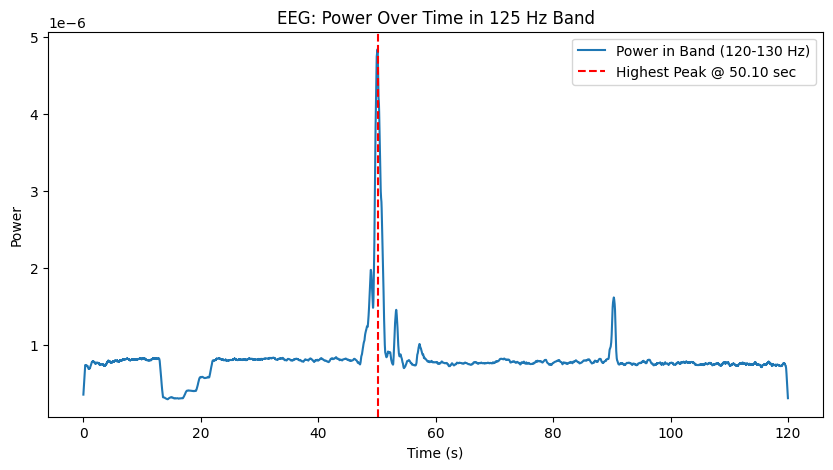

Available blocks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Reading recording 0...
DBS peak time logged in sync_log.txt


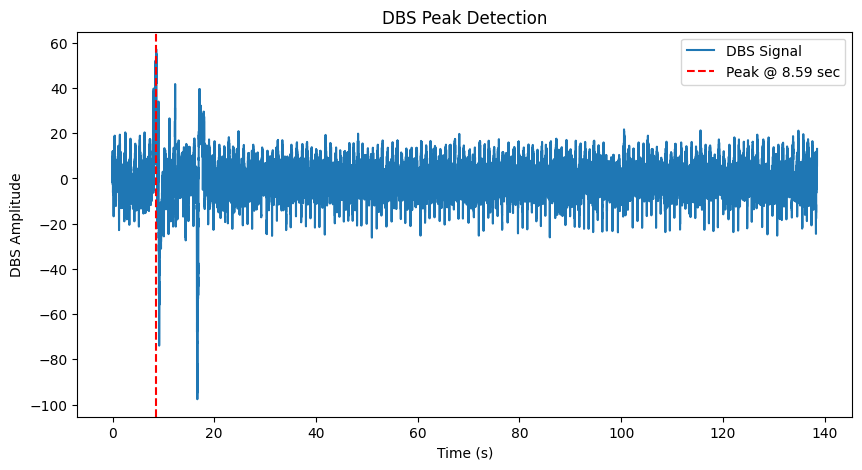

In [8]:
# Load EEG
eeg_data = load_eeg_data(eeg_file)
eeg_fs = eeg_data.info["sfreq"]

# Find EEG peak
eeg_peak_fs = find_eeg_peak(eeg_data, 120, 130, 4, duration_sec=120)

# Load DBS
json_data = open_json_file(dbs_file)
block_num = select_recording(json_data)
dbs_data = read_time_domain_data(json_data, block_num)

# Find DBS peak
dbs_peak_fs = find_dbs_peak(dbs_data)

In [9]:
# Synchronize EEG and cropped DBS
cropped_eeg, cropped_dbs = crop_data(eeg_data, dbs_data, dbs_peak_fs, eeg_peak_fs)
print("EEG and DBS cropped at the synchronization peak.")

Cropped EEG length: 1.7379916666666666 minutes
Cropped DBS length: 2.165133333333333 minutes
EEG and DBS cropped at the synchronization peak.


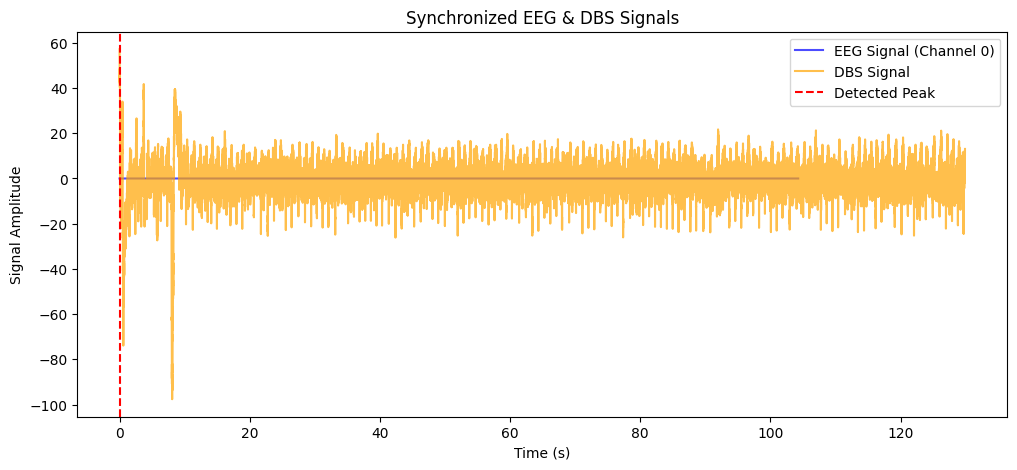

In [12]:
# Plot synchronized signals
synchonized_eeg, synchronized_dbs = synchronize_data(cropped_eeg, cropped_dbs)

In [14]:
save_synchronized_data(synchonized_eeg, synchronized_dbs)

Writing /Users/lenasalzmann/dev/dbs-eeg-sync/notebooks/data/synchronized_eeg.fif
Closing /Users/lenasalzmann/dev/dbs-eeg-sync/notebooks/data/synchronized_eeg.fif
[done]
Saved synchronized EEG to data/synchronized_eeg.fif
Saved synchronized DBS to data/synchronized_dbs.csv
